In [53]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

In [2]:
# === 1. ODB GLODAP API fetch ===
cruise = "21OR19910626" # OR1_287 in 1991
glodap_url = "https://ecodata.odb.ntu.edu.tw/glodap/v2/2023/"
glodap_params = {
    "cruise": cruise,
    "append": "temperature,salinity,oxygen"
}
resp_glodap = requests.get(glodap_url, params=glodap_params)
resp_glodap.raise_for_status()
glodap_df = pd.DataFrame(resp_glodap.json())

In [3]:
print(glodap_df.head())

       expocode station  region  cast_number  year  month  latitude  \
0  21OR19910626     9.0       8            1  1991      6     21.75   
1  21OR19910626     9.0       8            1  1991      6     21.75   
2  21OR19910626     9.0       8            1  1991      6     21.75   
3  21OR19910626     9.0       8            1  1991      6     21.75   
4  21OR19910626     9.0       8            1  1991      6     21.75   

   longitude  bottomdepth  maxsampdepth  bottle  pressure  depth  \
0      122.0       4000.0         995.0    10.0     350.0  348.0   
1      122.0       4000.0         995.0     9.0     550.0  546.0   
2      122.0       4000.0         995.0     8.0     699.0  693.0   
3      122.0       4000.0         995.0     7.0     850.0  843.0   
4      122.0       4000.0         995.0     6.0     995.0  986.0   

               datetime                                                doi  \
0  1991-06-27T02:54:00Z  https://doi.org/10.3334/cdiac/otg.pacifica_21o...   
1  1991-

In [4]:
# === 2. Compute bounding box with 0.5 deg buffer ===
buffer = 0.5
lon0 = glodap_df["longitude"].min() - buffer
lon1 = glodap_df["longitude"].max() + buffer
lat0 = glodap_df["latitude"].min() - buffer
lat1 = glodap_df["latitude"].max() + buffer
print(f"Bounding box: ({lon0}, {lat0}), ({lon1}, {lat1})") 

Bounding box: (120.39, 21.248), (129.5, 22.412)


In [5]:
# === 3. ODB WOA23 API fetch ===
woa_url = "https://eco.odb.ntu.edu.tw/api/woa23"
# Finer grid for temperature/salinity
woa_params_ts = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "parameter": "temperature,salinity",
    "grid": 0.25,
    "time_period": 0,
    "append": "an"
}
# Coarser grid for oxygen
woa_params_o2 = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "parameter": "oxygen",
    "grid": 1,
    "time_period": 0,
    "append": "an"
}
resp_woa_ts = requests.get(woa_url, params=woa_params_ts)
resp_woa_ts.raise_for_status()
woa_ts_df = pd.DataFrame(resp_woa_ts.json())

resp_woa_o2 = requests.get(woa_url, params=woa_params_o2)
resp_woa_o2.raise_for_status()
woa_o2_df = pd.DataFrame(resp_woa_o2.json())


In [6]:
print(woa_ts_df.head())
woa_ts_df.shape[0]

       lon     lat  depth time_period  salinity_an  temperature_an
0  120.375  21.125    0.0           0    34.153111       27.218790
1  120.625  21.125    0.0           0    34.209099       27.257910
2  120.875  21.125    0.0           0    34.269402       27.288799
3  121.125  21.125    0.0           0    34.329399       27.304890
4  121.375  21.125    0.0           0    34.385513       27.303690


23256

In [7]:
print(woa_o2_df.head())
woa_o2_df.shape[0]

     lon   lat  depth time_period   oxygen_an
0  120.5  21.5    0.0           0  202.689224
1  121.5  21.5    0.0           0  202.203903
2  122.5  21.5    0.0           0  201.562378
3  123.5  21.5    0.0           0  202.162308
4  124.5  21.5    0.0           0  202.827942


2040

In [22]:
# Outer join to preserve all points from different resolution grids
woa_df = pd.merge(woa_ts_df, woa_o2_df, on=["lon", "lat", "depth", "time_period"], how="outer")


In [29]:
woa_df[woa_df.oxygen_an.notnull()]


,lon,lat,depth,time_period,salinity_an,temperature_an,oxygen_an
612,120.5,21.5,0.0,0,NaN,NaN,202.689224
613,120.5,21.5,5.0,0,NaN,NaN,201.918747
614,120.5,21.5,10.0,0,NaN,NaN,201.036728
615,120.5,21.5,15.0,0,NaN,NaN,200.326538
616,120.5,21.5,20.0,0,NaN,NaN,199.183456
...,...,...,...,...,...,...,...
24677,129.5,22.5,4900.0,0,NaN,NaN,157.000183
24678,129.5,22.5,5000.0,0,NaN,NaN,158.200089
24679,129.5,22.5,5100.0,0,NaN,NaN,160.135742
24680,129.5,22.5,5200.0,0,NaN,NaN,160.793610


In [16]:
# === 4. ODB CTD API fetch ===
ctd_url = "https://ecodata.odb.ntu.edu.tw/api/ctd"
ctd_params = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "mode": 0,
    "append": "temperature,salinity,oxygen"
}
resp_ctd = requests.get(ctd_url, params=ctd_params)
resp_ctd.raise_for_status()
ctd_df = pd.DataFrame(resp_ctd.json())

In [17]:
print(ctd_df.head())
ctd_df.shape[0]

   longitude  latitude time_period  depth  temperature  salinity   oxygen
0      120.5     21.25           0    396       10.455    34.409  126.566
1      120.5     21.25           0    158       19.653    34.761  158.605
2      120.5     21.25           0      1       28.070    33.915  192.824
3      120.5     21.25           0    650        7.012    34.413   97.836
4      120.5     21.25           0    397       10.438    34.407  126.680


168454

In [ ]:
print(ctd_df[(ctd_df['depth']>=400) & (ctd_df['depth']<=500) & (ctd_df['longitude']>=127.5) & (ctd_df['longitude']<=129.5)][['longitude','latitude','depth','salinity']])

        longitude  latitude  depth  salinity
156820      127.5     21.25    400    34.501
156822      127.5     21.25    401    34.498
156824      127.5     21.25    402    34.498
156826      127.5     21.25    403    34.496
156828      127.5     21.25    404    34.494
...           ...       ...    ...       ...
167997      129.5     21.75    496    33.746
167998      129.5     21.75    497    33.743
167999      129.5     21.75    498    33.738
168000      129.5     21.75    499    33.737
168001      129.5     21.75    500    33.734

[576 rows x 4 columns]


In [73]:
# === 5. Shared Plotting Functions ===
def plot_profile_average(df, api_name, param_keys, param_names, units, lon_col, lat_col, max_depth=2000):
    fig, axs = plt.subplots(3, 1, figsize=(8, 14), constrained_layout=True)
    for i, param in enumerate(param_keys):
        df_clean = df[[lon_col, lat_col, 'depth', param]].dropna()
        df_clean = df_clean[df_clean['depth']<=max_depth]
        df_grouped = df_clean.groupby([lon_col,'depth'])[param].mean().reset_index()
        lons = df_grouped[lon_col].values
        depths = df_grouped['depth'].values
        values = df_grouped[param].values
        unique_lons = np.unique(lons)
        unique_depths = np.unique(depths)
        x, y = np.meshgrid(unique_lons, unique_depths)
        mesh = np.full_like(x, np.nan, dtype=np.float32)
        for j in range(len(values)):
            lon_idx = np.where(unique_lons==lons[j])[0][0]
            depth_idx = np.where(unique_depths==depths[j])[0][0]
            mesh[depth_idx, lon_idx] = values[j]
        levels = 128 if 'temperature' in param or 'oxygen' in param else 32
        cs = axs[i].contourf(x, y, mesh, cmap='coolwarm', levels=levels)
        cbar = fig.colorbar(cs, ax=axs[i])
        cbar.set_label(f"{param_names[i]} ({units[i]})")
        axs[i].invert_yaxis()
        axs[i].set_ylabel('Depth (m)')
        axs[i].set_title(f"{param_names[i]} Profile")
    axs[-1].set_xlabel('Longitude (°E)')
    xticks = np.arange(int(unique_lons.min()), int(unique_lons.max()) + 1)
    for ax in axs:
        ax.set_xticks(xticks)
    fig.suptitle(f"{api_name} Depth Profiles (Lat‑Averaged)")
    plt.show()

# === 6. Improved Scatter Plot for GLODAP ===
def plot_glodap_profiles(df, api_name, param_keys, param_names, units):
    from matplotlib.colors import Normalize

    fig, axs = plt.subplots(3, 1, figsize=(6, 12), constrained_layout=True)
    norm = Normalize(vmin=df['longitude'].min(), vmax=df['longitude'].max())
    cmap = plt.colormaps['viridis']

    for i, param in enumerate(param_keys):
        for station in df['station'].unique():
            sub = df[df['station'] == station].sort_values("depth")
            lon = sub["longitude"].mean()
            color = cmap(norm(lon))
            axs[i].plot(sub[param], sub["depth"], marker="o", linestyle="-", alpha=0.6, color=color)
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{param_names[i]} ({units[i]})")
        axs[i].set_ylabel("Depth (m)")
        axs[i].set_title(f"{param_names[i]} Profile")
        axs[i].grid(True)
    fig.suptitle(f"OR1-287 Bottle Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()



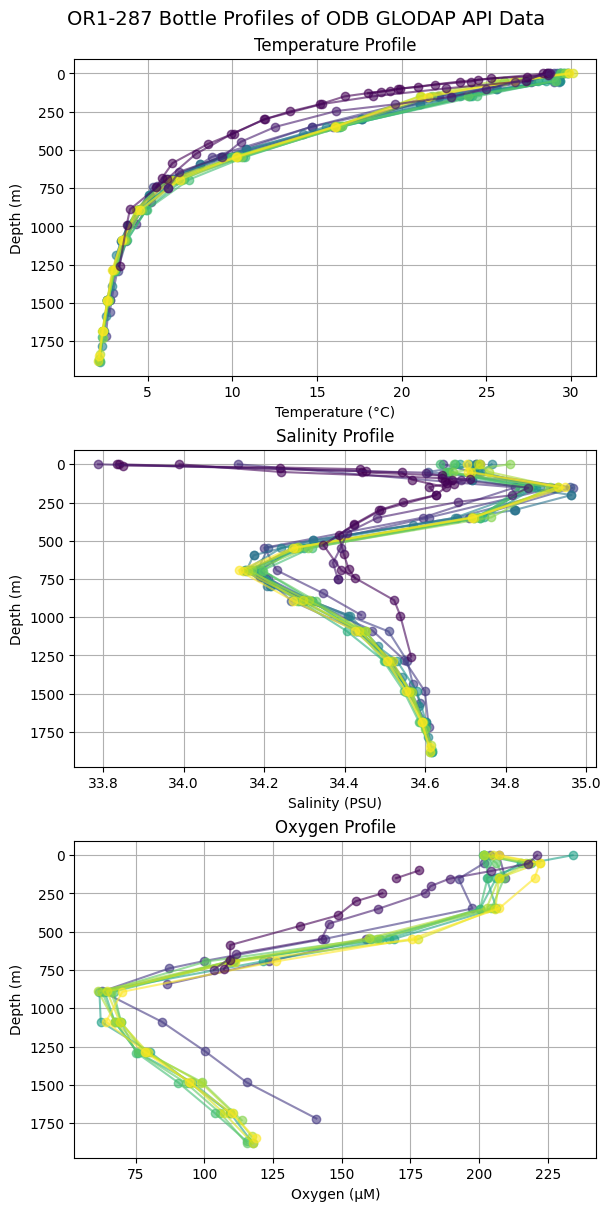

In [74]:
# === 6. Plot each API ===
plot_glodap_profiles(glodap_df, "GLODAP", ["temperature", "salinity", "oxygen"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"])



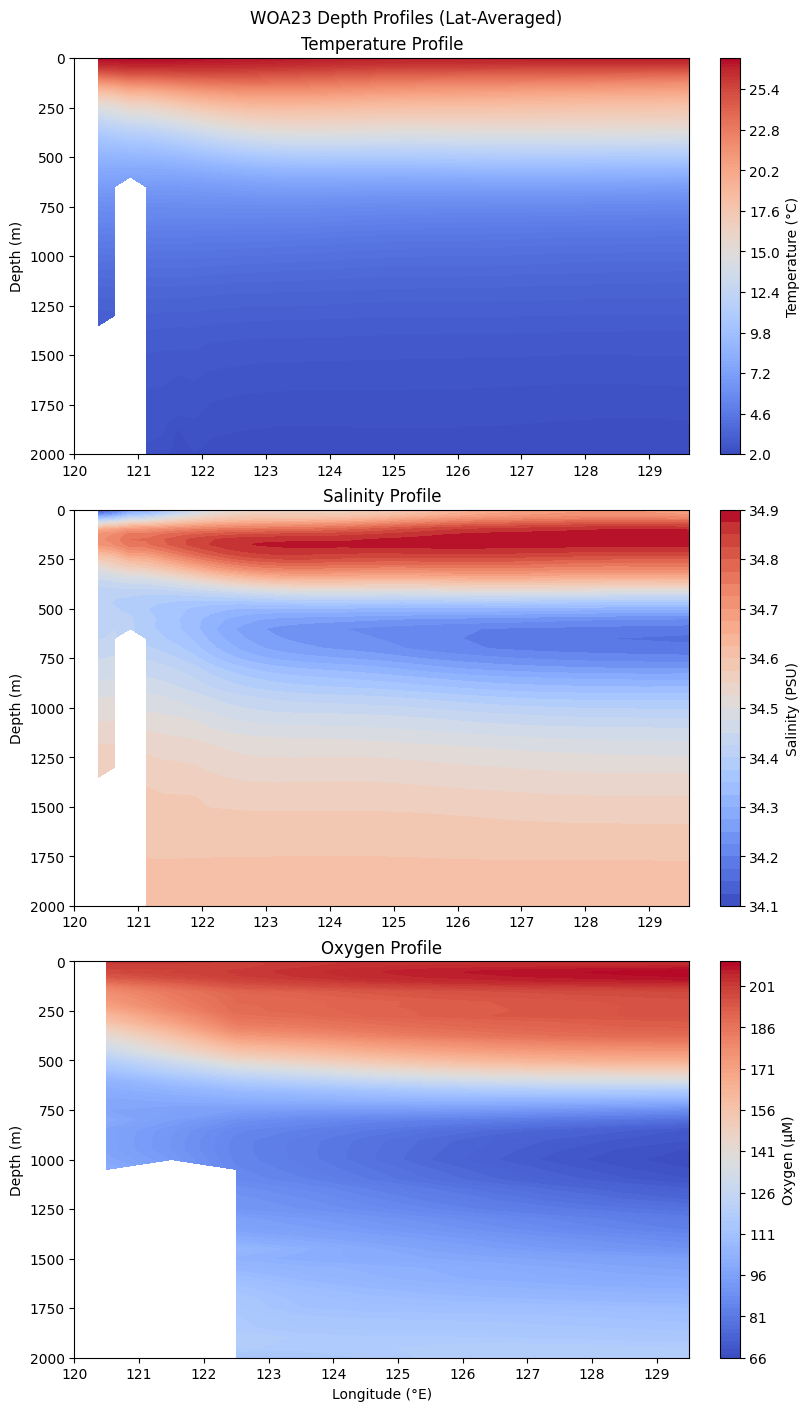

In [71]:
plot_profile_average(woa_df, "WOA23", ["temperature_an", "salinity_an", "oxygen_an"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"], lon_col="lon", lat_col="lat", max_depth=2000)


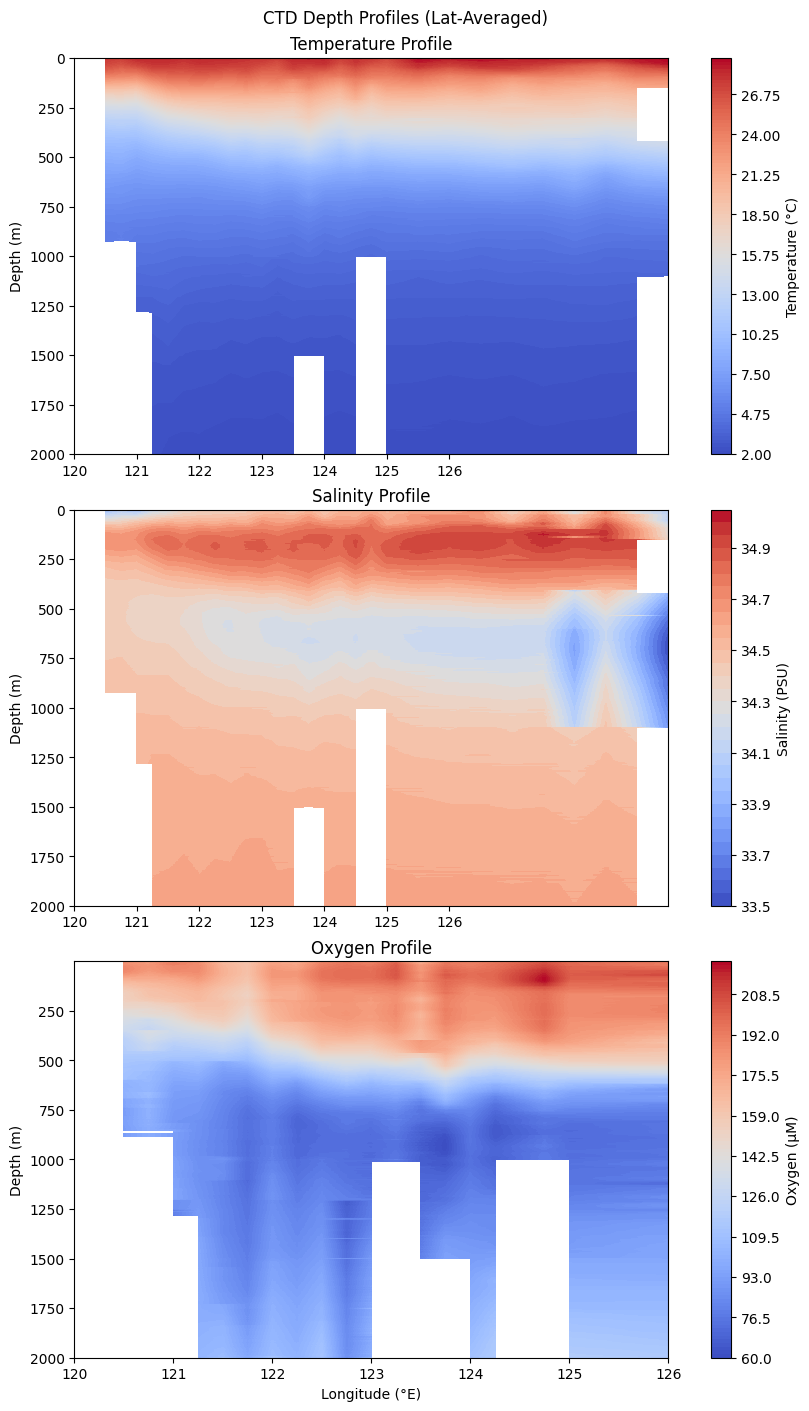

In [72]:
plot_profile_average(ctd_df, "CTD", ["temperature", "salinity", "oxygen"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"], lon_col="longitude", lat_col="latitude", max_depth=2000)